In [4]:
import re
import xapian
import pandas as pd
import numpy as np
import csv

In [5]:
import json

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
pd.options.display.max_colwidth = 200
pd.options.display.precision = 2

In [8]:
DBPATH = "ner_sents_index"
#SOURCES = ['dev', 'train', 'test']
SOURCES = ['dev']
#SOURCES = ['test']
#SOURCES = ['train']
SEARCH_RESULT_PATH = "data/search_results_v4_{}.csv".format(SOURCES[0])

!xapian-delve $DBPATH

!xapian-delve -r 140001 -d $DBPATH

# Retrieve documents relevant to claims

In [6]:
import spacy
import en_core_web_lg

nlp = en_core_web_lg.load()
def parse_with_spacy(text):
    doc = nlp(text)
    record = dict(
        named_entities = [{'entity': span.text, 'label': span.label_, 'root': span.root.text} for span in doc.ents],
        noun_phrases = [{'noun_phrase': span.text, 'root': span.root.text} for span in doc.noun_chunks]
    )
    return record

def preprocess_ner(s):
    #s = re.sub("^(The|the|A|a|An|an)\s", "", s)
    #s = re.sub("\s", "_", s) 
    #s = re.sub("-", "_", s)
    return s

def obtain_nouns(v):
    ents = {preprocess_ner(item['entity']) for item in v['named_entities']}
    ents_roots = {preprocess_ner(item['root']) for item in v['named_entities']}
    nps = {preprocess_ner(item['noun_phrase']) for item in v['noun_phrases']}
    nps_roots = {preprocess_ner(item['root']) for item in v['noun_phrases']}
    return ents.union(nps).union(ents_roots).union(nps_roots)

In [7]:
def get_doc_id(match):
    for term in match.document.termlist():
        term = term.term.decode("utf-8") 
        m = re.match("Q(.*)", term)
        if m:
            return m[1]
    return None

In [ ]:
# Prepare enquiry object

# Open the database we're going to search.
db = xapian.Database(DBPATH)

# Set up a QueryParser with a stemmer and suitable prefixes
queryparser = xapian.QueryParser()
#queryparser.set_stemmer(xapian.Stem("en"))
#queryparser.set_stemming_strategy(queryparser.STEM_SOME)
queryparser.add_prefix('keywords', 'K')
queryparser.add_prefix('page_id', 'S')

# Use an Enquire object on the database to run the query
enquire = xapian.Enquire(db)    

In [9]:
#query = 'keywords:"1992_Los_Angeles_Raiders_season nfl" first time in three seasons the team failed'
query = '+(page_id:santana__lrb_surname_rrb_ page_id:alfortville_armenian_genocide_memorial_bombings) cocktails'
#qeury


query = queryparser.parse_query(query)
print(query)
enquire.set_query(query)
matches = enquire.get_mset(0, 100)

query_results = []
for match in matches:
    result = dict(
        #claim_id = claim_id,
        found_doc = get_doc_id(match),
        rank = match.rank + 1,
        percentage = match.percent,
        weight = match.weight,            
    )
    query_results.append(result)
query_results

Query(((Ssantana__lrb_surname_rrb_@1 OR Salfortville_armenian_genocide_memorial_bombings@2) AND_MAYBE cocktails@3))


[{'found_doc': 'Alfortville_Armenian_Genocide_Memorial_bombings_17',
  'percentage': 66,
  'rank': 1,
  'weight': 9.950367485989108},
 {'found_doc': 'Alfortville_Armenian_Genocide_Memorial_bombings_0',
  'percentage': 0,
  'rank': 2,
  'weight': 0.0},
 {'found_doc': 'Alfortville_Armenian_Genocide_Memorial_bombings_1',
  'percentage': 0,
  'rank': 3,
  'weight': 0.0},
 {'found_doc': 'Alfortville_Armenian_Genocide_Memorial_bombings_4',
  'percentage': 0,
  'rank': 4,
  'weight': 0.0},
 {'found_doc': 'Alfortville_Armenian_Genocide_Memorial_bombings_5',
  'percentage': 0,
  'rank': 5,
  'weight': 0.0},
 {'found_doc': 'Alfortville_Armenian_Genocide_Memorial_bombings_6',
  'percentage': 0,
  'rank': 6,
  'weight': 0.0},
 {'found_doc': 'Alfortville_Armenian_Genocide_Memorial_bombings_7',
  'percentage': 0,
  'rank': 7,
  'weight': 0.0},
 {'found_doc': 'Alfortville_Armenian_Genocide_Memorial_bombings_8',
  'percentage': 0,
  'rank': 8,
  'weight': 0.0},
 {'found_doc': 'Alfortville_Armenian_Gen

In [15]:
claim_df = pd.read_json('data/claims_lm.json').sort_index()

In [16]:
mask = claim_df.source.isin(SOURCES)
claim_df = claim_df[mask]

In [12]:
from utils import KeywordsAndEntityTask

processor = KeywordsAndEntityTask()

In [13]:
%%time
#claim_df['search_words'] = claim_df.claim.apply(processor.extract_keyword_list)
#claim_df['search_words'] = claim_df.claim.apply(parse_with_spacy).apply(obtain_nouns)
#claim_df['search_words'] = claim_df.claim.apply(processor.extract_keyword_list)
#(claim_df.np_phrase + claim_df.np_roots).apply(lambda x: list(np.unique(x)))

CPU times: user 23 µs, sys: 1 µs, total: 24 µs
Wall time: 27.9 µs


In [14]:
claim_df.head()

,claim,source,named_entities,noun_phrases,entity_count,entity_types,entity_types_count,np_count,np_phrase,np_roots
3,Chris Hemsworth appeared in A Perfect Getaway.,train,"[{'entity': 'Chris Hemsworth', 'label': 'PERSON', 'root': 'Hemsworth'}, {'entity': 'A Perfect Getaway', 'label': 'WORK_OF_ART', 'root': 'Getaway'}]","[{'noun_phrase': 'Chris Hemsworth', 'root': 'Hemsworth'}, {'noun_phrase': 'A Perfect Getaway', 'root': 'Getaway'}]",2,"[WORK_OF_ART, PERSON]",2,2,"[Chris Hemsworth, A Perfect Getaway]","[Getaway, Hemsworth]"
4,Chris Hemsworth disappeared in A Perfect Getaway.,train,"[{'entity': 'Chris Hemsworth', 'label': 'PERSON', 'root': 'Hemsworth'}, {'entity': 'A Perfect Getaway', 'label': 'WORK_OF_ART', 'root': 'Getaway'}]","[{'noun_phrase': 'Chris Hemsworth', 'root': 'Hemsworth'}, {'noun_phrase': 'A Perfect Getaway', 'root': 'Getaway'}]",2,"[WORK_OF_ART, PERSON]",2,2,"[Chris Hemsworth, A Perfect Getaway]","[Getaway, Hemsworth]"
7,Roald Dahl is a writer.,train,"[{'entity': 'Roald Dahl', 'label': 'PERSON', 'root': 'Dahl'}]","[{'noun_phrase': 'Roald Dahl', 'root': 'Dahl'}, {'noun_phrase': 'a writer', 'root': 'writer'}]",1,[PERSON],1,2,"[a writer, Roald Dahl]","[Dahl, writer]"
8,Roald Dahl is a governor.,train,"[{'entity': 'Roald Dahl', 'label': 'PERSON', 'root': 'Dahl'}]","[{'noun_phrase': 'Roald Dahl', 'root': 'Dahl'}, {'noun_phrase': 'a governor', 'root': 'governor'}]",1,[PERSON],1,2,"[a governor, Roald Dahl]","[Dahl, governor]"
9,Ireland has relatively low-lying mountains.,train,"[{'entity': 'Ireland', 'label': 'GPE', 'root': 'Ireland'}]","[{'noun_phrase': 'Ireland', 'root': 'Ireland'}, {'noun_phrase': 'relatively low-lying mountains', 'root': 'mountains'}]",1,[GPE],1,2,"[Ireland, relatively low-lying mountains]","[Ireland, mountains]"


In [15]:
claim_df.shape

(145449, 10)

In [16]:
found_docs_df = pd.read_csv('data/search_results_v2.csv')
found_docs_df = found_docs_df[found_docs_df['rank'] <= 25]

In [17]:
#search_df = found_docs_df.set_index('claim_id').join(claim_df[['search_words', 'claim']], how='inner')
search_df = found_docs_df.set_index('claim_id').join(claim_df[['claim']], how='inner')

In [18]:
search_df.head()

,found_doc,rank,percentage,weight,claim
3,Chris_Hemsworth,1,63,35.87,Chris Hemsworth appeared in A Perfect Getaway.
3,Hemsworth_-LRB-surname-RRB-,2,47,26.92,Chris Hemsworth appeared in A Perfect Getaway.
3,Kim_Hyde,3,39,22.10,Chris Hemsworth appeared in A Perfect Getaway.
3,Liam_Hemsworth,4,38,21.55,Chris Hemsworth appeared in A Perfect Getaway.
3,Vanessa_Zachos,5,37,21.33,Chris Hemsworth appeared in A Perfect Getaway.


In [19]:
%%time
fields = ['claim_id', 'found_doc', 'sent_id', 'rank', 'percentage', 'weight', 'text']
pagesize = 5
i = 0
#results = []

with open(SEARCH_RESULT_PATH, 'w') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=fields)
    writer.writeheader()

    for claim_id, data in search_df.iterrows():
        #page_id, _, _, _, keywords, claim = data
        try:
            page_id, _, _, _, claim = data

            if i % 5000 == 0:
                print(i // 5000, claim_id)
            i += 1

            page = re.sub('-', '_', page_id.lower())
            #query_str = '+page_id:{} keywords:{} {}'.format(page, " ".join(keywords), claim)
            query_str = '+page_id:{} {}'.format(page, claim)
            #query_str = '+page_id:{} {} {}'.format(page, " ".join(keywords), claim)
            #query_str = '+page_id:{} keywords:{}'.format(page, " keywords:".join(keywords))
            #query_str = 'keywords:{}'.format(page, " keywords:".join(keywords))

            #print(query_str)
            query = queryparser.parse_query(query_str)
            #print(query)
            enquire.set_query(query)
            matches = enquire.get_mset(0, pagesize)

            query_results = []
            for match in matches:
                fields = json.loads(match.document.get_data())
                page_id = fields['page_id']
                sent_id = fields['sentence_id']
                text = fields['text']


                result = dict(
                    claim_id = claim_id,
                    found_doc = page_id,
                    sent_id = sent_id,
                    rank = match.rank + 1,
                    percentage = match.percent,
                    weight = round(match.weight, 2),
                    text = text
                )
                query_results.append(result)

            writer.writerows(query_results)
        except Exception as e:
            print('failed to process {} - {}, Error: {}', claim_id, data, e)
        #results += query_results
csvFile.close()

0 3
1 290
2 632
3 935
4 1266
5 1575
6 1879
7 2188
8 2515
9 2816
10 3140
11 3436
12 3756
13 4050
14 4366
15 4665
16 4982
17 5280
18 5570
19 5866
20 6182
21 6467
22 6735
23 7009
24 7317
25 7617
26 7909
27 8192
28 8491
29 8806
30 9102
31 9398
32 9724
33 10013
34 10359
35 10645
36 10949
37 11261
38 11598
39 11886
40 12182
41 12497
42 12788
43 13090
44 13403
45 13695
46 14012
47 14324
48 14638
49 14925
50 15241
51 15525
52 15814
53 16116
54 16439
55 16735
56 17014
57 17295
58 17604
failed to process {} - {}, Error: {} 17674 found_doc                                              NaN
rank                                                    23
percentage                                              57
weight                                                  16
claim         Point Place is in Wisconsin and is not real.
Name: 17674, dtype: object 'float' object has no attribute 'lower'
59 17892
60 18194
61 18500
62 18790
63 19107
64 19405
65 19703
66 19997
67 20313
68 20624
69 20932
70 21207
71 21

714 225343
715 225628
716 225992
717 226285
718 226563
719 226898
720 227261
721 227602
722 227842
723 228152
724 228449
725 228817
726 229064
727 229399
CPU times: user 30min 27s, sys: 8min 32s, total: 39min
Wall time: 42min 1s


In [13]:
!python score.py temp/testoutput.json temp/testoutput_new.json

Error processing line 2 of /anaconda/lib/python3.6/site-packages/gapic_google_cloud_datastore_v1-0.15.3-py3.6-nspkg.pth:

  Traceback (most recent call last):
    File "/anaconda/lib/python3.6/site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  KeyError: 'google'

Remainder of file ignored
Label Accuracy 		64.79%
Sentence Precision 	84.36%
Sentence Recall 	68.53%
Sentence F1 		75.62%
Document Precision 	90.38%
Document Recall 	73.31%
Document F1 		80.95%


# Analyse Found Documents

## Read claims

In [9]:
sources = SOURCES
if 'test' in sources:
    sources.remove('test')
    
labelled_claims_df = pd.read_json('data/l_claims.json').sort_index()
labelled_claims_df.index.name = 'claim_id'
mask = labelled_claims_df.source.isin(sources)
labelled_claims_df = labelled_claims_df[mask]

## Read search results

In [10]:
import unicodedata

In [11]:
results_df = pd.read_csv(SEARCH_RESULT_PATH)
normalise = lambda item: unicodedata.normalize('NFD', item) if isinstance(item, str) else item
results_df['found_doc'] = results_df['found_doc'].apply(normalise)
#results_df.set_index('claim_id', inplace=True)

In [12]:
results_df.head()
#results_df = results_df.sample(int(1e6))

,claim_id,found_doc,sent_id,rank,percentage,weight,text
0,12,Santana_-LRB-surname-RRB-,7,1,57,36.10,"Jorge Santana (born 1951), musician and brother of Carlos Santana"
1,12,Santana_-LRB-surname-RRB-,9,2,57,36.10,"Salvador Santana (born 1983), musician and son of Carlos Santana"
2,12,Santana_-LRB-surname-RRB-,3,3,48,30.94,"Carlos Santana (born 1947), Mexican-American guitarist"
3,12,Santana_-LRB-surname-RRB-,13,4,36,22.89,"Johan Santana (born 1979), pitcher in Major League Baseball"
4,12,Santana_-LRB-surname-RRB-,0,5,34,21.99,"Santana is a Latin surname, most common in Spanish speaking countries :"


In [24]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472605 entries, 0 to 472604
Data columns (total 7 columns):
claim_id      472605 non-null int64
found_doc     472605 non-null object
sent_id       472605 non-null int64
rank          472605 non-null int64
percentage    472605 non-null int64
weight        472605 non-null float64
text          472605 non-null object
dtypes: float64(1), int64(4), object(2)
memory usage: 25.2+ MB


In [25]:
results_df = results_df.join(claim_df.claim, on='claim_id')

In [26]:
#train_mask = labelled_claims_df.source == 'train'
golden_evidence = {(claim_id, evidence[0], evidence[1]) 
                        for claim_id, item in labelled_claims_df.evidence.items() \
                        for evidence in item
                  }

In [27]:
cols = ['claim_id', 'found_doc', 'sent_id']

In [28]:
func = lambda v: (v['claim_id'], v['found_doc'], v['sent_id']) in golden_evidence
results_df['label'] = results_df[cols].apply(func, axis=1)

In [29]:
results_df.label.sum()

3438

In [30]:
results_df.label = results_df.label.astype(int)

mask = results_df['label'] == 1
N = int(1e4)
train_df = pd.concat([results_df[mask].sample(N), results_df[~mask].sample(N)])

train_df[['claim', 'text', 'label']].to_csv('data/sentence_selection_training_set.csv', index=False)

## Estimate index-search performance

In [33]:
def calculate_recall(mask):
    func = lambda x: set(x)
    found_docs_df = results_df[mask].pivot_table(index='claim_id', values='found_doc', aggfunc=func)

    recall_df = labelled_claims_df[['evidence_docs', 'source', 'claim']].join(found_docs_df)

    def func(x):
        if isinstance(x['found_doc'], set):
            return set(x['evidence_docs']).difference(x['found_doc'])
        return set(x['evidence_docs'])

    recall_df['missed_docs'] = recall_df.apply(func, axis=1)
    recall_df['missed_count'] = recall_df['missed_docs'].apply(len)

    recall_df = recall_df.pivot_table(index='missed_count', columns='source',# margins=True,
                                                    values='claim', aggfunc='count', fill_value=0)
    return recall_df

results_df = labelled_claims_df[['claim']].join(results_df).reset_index()

In [36]:
results_df['row_number'] = results_df.sort_values(['claim_id', 'weight'], ascending=[True, False]) \
                                      .groupby('claim_id') \
                                      .cumcount() + 1

In [37]:
df = results_df[(results_df.row_number <= 5)].copy()

In [38]:
def get_pair(v):
    return list((v['found_doc'], v['sent_id']))
df['evidence'] = df.apply(get_pair, axis=1)

In [39]:
df = df.groupby(['claim_id', 'claim'])[['evidence']].agg(lambda x: list(x)).reset_index()
df['label'] = 'SUPPORTS'
df.set_index('claim_id', inplace=True)

In [40]:
df.to_json('test_set_results.json', orient='index')

In [41]:
!python score.py dev_results.json devset.json

Error processing line 2 of /anaconda/lib/python3.6/site-packages/gapic_google_cloud_datastore_v1-0.15.3-py3.6-nspkg.pth:

  Traceback (most recent call last):
    File "/anaconda/lib/python3.6/site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  KeyError: 'google'

Remainder of file ignored
Label Accuracy 		33.33%
Sentence Precision 	42.33%
Sentence Recall 	6.71%
Sentence F1 		11.59%
Document Precision 	53.90%
Document Recall 	8.74%
Document F1 		15.05%


In [42]:
%%time

results = []
for top in range(5, 101, 5):
    #print(top)
    mask = results_df['rank'] <= top
    
    recall_df = calculate_recall(mask)
    
    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['top'] = top
    results += recall_df.to_dict(orient="records")

CPU times: user 12 s, sys: 1.13 s, total: 13.2 s
Wall time: 13.2 s


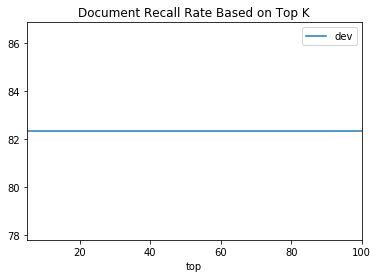

,dev
top,
5,82.32
10,82.32
15,82.32
20,82.32
25,82.32
30,82.32
35,82.32
40,82.32
45,82.32


In [43]:
df = pd.DataFrame.from_records(results).set_index('top')
df.plot.line(title='Document Recall Rate Based on Top K')
plt.show()
df#.T

In [44]:
results_df.head()

,claim_id,found_doc,sent_id,rank,percentage,weight,text,claim,label,row_number
0,12,Santana_-LRB-surname-RRB-,7,1,57,36.10,"Jorge Santana (born 1951), musician and brother of Carlos Santana",Carlos Santana disbanded Santana in 1965.,0,4
1,12,Santana_-LRB-surname-RRB-,9,2,57,36.10,"Salvador Santana (born 1983), musician and son of Carlos Santana",Carlos Santana disbanded Santana in 1965.,0,5
2,12,Santana_-LRB-surname-RRB-,3,3,48,30.94,"Carlos Santana (born 1947), Mexican-American guitarist",Carlos Santana disbanded Santana in 1965.,0,18
3,12,Santana_-LRB-surname-RRB-,13,4,36,22.89,"Johan Santana (born 1979), pitcher in Major League Baseball",Carlos Santana disbanded Santana in 1965.,0,41
4,12,Santana_-LRB-surname-RRB-,0,5,34,21.99,"Santana is a Latin surname, most common in Spanish speaking countries :",Carlos Santana disbanded Santana in 1965.,0,44


In [45]:
%%time

results = []
for top in range(5, 101, 5):
    #print(top)
    mask = results_df['percentage'] >= top
    
    recall_df = calculate_recall(mask)

    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['percentage'] = top
    results += recall_df.to_dict(orient="records")

CPU times: user 10.9 s, sys: 427 ms, total: 11.4 s
Wall time: 11.4 s


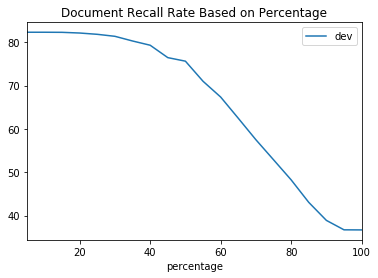

,dev
percentage,
5,82.32
10,82.32
15,82.30
20,82.14
25,81.84
30,81.38
35,80.30
40,79.32
45,76.46


In [46]:
df = pd.DataFrame.from_records(results).set_index('percentage')
df.plot.line(title='Document Recall Rate Based on Percentage')
plt.show()
df#.T

In [47]:
results_df.shape[0], results_df[results_df.weight > 14].shape

(472605, (129136, 10))

In [48]:
%%time

results = []
for top in range(10, 25, 1):
    #print(top)
    mask = results_df['weight'] >= top
    
    recall_df = calculate_recall(mask)

    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['weight'] = top
    results += recall_df.to_dict(orient="records")

CPU times: user 7.11 s, sys: 190 ms, total: 7.3 s
Wall time: 7.3 s


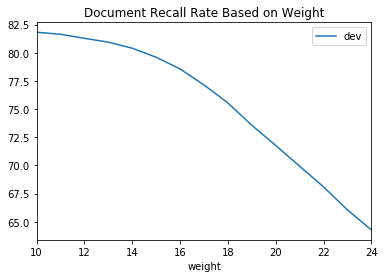

,dev
weight,
10,81.82
11,81.64
12,81.28
13,80.94
14,80.40
15,79.60
16,78.56
17,77.14
18,75.54


In [49]:
df = pd.DataFrame.from_records(results).set_index('weight')
df.plot.line(title='Document Recall Rate Based on Weight')
plt.show()
df#.T

## Search performance with filters applied

In [50]:
mask = (results_df['rank'] <= 10) #& (results_df.weight > 10) #& (results_df.percentage > 25)
recall_df = calculate_recall(mask)
recall_df = (recall_df / recall_df.sum() * 100)#.head(1)
recall_df.head(1)

source,dev
missed_count,
0,82.32


In [51]:
results_df.found_doc.unique().shape[0], results_df[mask].found_doc.unique().shape[0] 

(56582, 56582)

In [52]:
mask = (results_df['rank'] <= 25)
processed_docs = results_df[mask].found_doc.unique()
len(processed_docs)

56582

In [53]:
mask = (results_df['rank'] <= 50)
docs = results_df[mask].found_doc.unique()
len(docs)

56582

In [54]:
docs = list(set(docs).difference(set(processed_docs)))
len(docs)

0

In [55]:
with open('data/top_26-50_docs.json', 'w') as fp:
    json.dump(list(docs), fp)

## Prepare submission

In [56]:
mask = (results_df['rank'] <= 10) & (results_df.percentage > 25) & (results_df.weight > 15)
submission_df = results_df[mask].set_index('claim_id')[['found_doc']].join(claim_df.claim)
submission_df.head()

,found_doc,claim
12,Santana_-LRB-surname-RRB-,Carlos Santana disbanded Santana in 1965.
12,Santana_-LRB-surname-RRB-,Carlos Santana disbanded Santana in 1965.
12,Santana_-LRB-surname-RRB-,Carlos Santana disbanded Santana in 1965.
12,Santana_-LRB-surname-RRB-,Carlos Santana disbanded Santana in 1965.
12,Santana_-LRB-surname-RRB-,Carlos Santana disbanded Santana in 1965.


In [57]:
results_df.shape, submission_df.shape,

((472605, 10), (110756, 2))

In [58]:
results_df.head()

,claim_id,found_doc,sent_id,rank,percentage,weight,text,claim,label,row_number
0,12,Santana_-LRB-surname-RRB-,7,1,57,36.10,"Jorge Santana (born 1951), musician and brother of Carlos Santana",Carlos Santana disbanded Santana in 1965.,0,4
1,12,Santana_-LRB-surname-RRB-,9,2,57,36.10,"Salvador Santana (born 1983), musician and son of Carlos Santana",Carlos Santana disbanded Santana in 1965.,0,5
2,12,Santana_-LRB-surname-RRB-,3,3,48,30.94,"Carlos Santana (born 1947), Mexican-American guitarist",Carlos Santana disbanded Santana in 1965.,0,18
3,12,Santana_-LRB-surname-RRB-,13,4,36,22.89,"Johan Santana (born 1979), pitcher in Major League Baseball",Carlos Santana disbanded Santana in 1965.,0,41
4,12,Santana_-LRB-surname-RRB-,0,5,34,21.99,"Santana is a Latin surname, most common in Spanish speaking countries :",Carlos Santana disbanded Santana in 1965.,0,44


In [59]:
results_df.found_doc.unique().shape, submission_df.found_doc.unique().shape

((56582,), (26195,))

In [60]:
submission_df['label'] = "SUPPORTS"
submission_df['evidence'] = submission_df.found_doc.apply(lambda x: [[x, 0]])

In [52]:
del submission_df['found_doc']

In [53]:
#submission_df.to_json('testoutput.json', orient='index')

In [54]:
submission_df.shape

(300013, 3)

## Evidence found

In [55]:
found_docs_df = results_df.pivot_table(index='claim_id', values='found_doc', aggfunc=list)
recall_df = labelled_claims_df[['evidence_docs', 'source', 'claim']].join(found_docs_df)

def func(x):
    if isinstance(x['found_doc'], list):
        return set(x['evidence_docs']).difference(set(x['found_doc']))
    return set(x['evidence_docs'])

recall_df['missed_docs'] = recall_df.apply(func, axis=1)
recall_df['missed_count'] = recall_df['missed_docs'].apply(len)

In [56]:
recall_df[recall_df.missed_count > 0]

,evidence_docs,source,claim,found_doc,missed_docs,missed_count
claim_id,,,,,,
7,[Roald_Dahl],train,Roald Dahl is a writer.,"[Roald_Dahl_Museum_and_Story_Centre, Roald_Dahl_Museum_and_Story_Centre, The_Collected_Short_Stories_of_Roald_Dahl, The_Collected_Short_Stories_of_Roald_Dahl, Roald_Dahl_Children's_Gallery, Roald_...",{Roald_Dahl},1
8,[Roald_Dahl],train,Roald Dahl is a governor.,"[The_Collected_Short_Stories_of_Roald_Dahl, The_Collected_Short_Stories_of_Roald_Dahl, Roald_Dahl_Children's_Gallery, Roald_Dahl_Children's_Gallery, Roald_Dahl_Children's_Gallery, Roald_Dahl_Child...",{Roald_Dahl},1
19,[H._H._Holmes],train,H. H. Holmes owned a building west of Chicago.,"[Henry_Holmes, Henry_Holmes, Henry_Holmes, Henry_Holmes, Henry_Holmes, Jackson_Boulevard_District_and_Extension, Jackson_Boulevard_District_and_Extension, Jackson_Boulevard_District_and_Extension,...",{H._H._Holmes},1
20,[H._H._Holmes],train,H. H. Holmes was the owner of a building located west of Chicago.,"[Henry_Holmes, Henry_Holmes, Henry_Holmes, Henry_Holmes, Henry_Holmes, Jackson_Boulevard_District_and_Extension, Jackson_Boulevard_District_and_Extension, Jackson_Boulevard_District_and_Extension,...",{H._H._Holmes},1
33,[Liverpool_F.C.],train,Liverpool F.C. was valued at $1.55 billion.,"[Seth_Klarman, Seth_Klarman, Seth_Klarman, Seth_Klarman, Seth_Klarman, BMW_Central_Building, BMW_Central_Building, Projections_of_population_growth, Projections_of_population_growth, Projections_o...",{Liverpool_F.C.},1
35,[Australia],train,Australia is a member of 8 intergovernmental organizations.,"[International_university, International_university, International_university, International_university, International_university, International_parliament, International_parliament, International...",{Australia},1
36,[Australia],train,Australia is not a member of 8 intergovernmental organizations.,"[Inter-parliamentary_institution, Inter-parliamentary_institution, Inter-parliamentary_institution, Inter-parliamentary_institution, Inter-parliamentary_institution, International_parliament, Inte...",{Australia},1
50,"[Xhosa_people, Nelson_Mandela]",train,Nelson Mandela is a person.,"[Nelson_Mandela_School, Nelson_Mandela_School, Nelson_Mandela_School, Nelson_Mandela_School, Nelson_Mandela_School, Mandela_Day, Mandela_Day, Mandela_Day, Mandela_Day, Mandela_Day, Nelson_Mandela_...","{Nelson_Mandela, Xhosa_people}",2
54,[Marilyn_Monroe],train,Marilyn Monroe was a part of an effort.,"[Marilyn_Monroe_-LRB-disambiguation-RRB-, Marilyn_Monroe_-LRB-disambiguation-RRB-, Marilyn_Monroe_-LRB-disambiguation-RRB-, Marilyn_Monroe_-LRB-disambiguation-RRB-, Marilyn_Monroe_-LRB-disambiguat...",{Marilyn_Monroe},1


In [57]:
found_df.evidence_docs.astype(str).value_counts().to_frame()

NameError: name 'found_df' is not defined

## Evidence missed

In [ ]:
missed_df = labelled_claims_df[labelled_claims_df.missed_count > 0]

In [ ]:
missed_df = missed_df.join(claim_df[['named_entities', 'np_phrase']])

In [ ]:
cols = ['claim', 'named_entities', 'np_phrase', 'evidence_docs',
       'evidence_doc_count', 'found_doc', 'missed_docs', 'missed_count']
missed_df.sort_values(['missed_count', 'evidence_set_str'], ascending=[False, True])[cols].head(100)

In [ ]:
missed_df.missed_docs.astype(str).value_counts().to_frame()